# Проект по демонстрации машинного обучения на данных о погоде

## Импорт библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import requests
import re

## Ссылка, URL-адрес и query-параметры

In [2]:
base_url = "https://archive-api.open-meteo.com/v1/archive"

latitude = 56.2
longitude = 44
start_date = '2020-01-01'
end_date = '2025-09-01'
timezone='Europe%2FMoscow'

params = ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
        'precipitation', 'rain', 'snowfall', 'snow_depth', 'surface_pressure', 'pressure_msl',
        'cloud_cover', 'wind_speed_10m', 'wind_gusts_10m', 'wind_direction_10m',
        'soil_temperature_0_to_7cm', 'soil_moisture_0_to_7cm', 'is_day', 'sunshine_duration']

## Получение набора метеоданных с Open-Meteo

In [3]:
def get_weather_data(latitude, longitude, start_date, end_date, hourly_params, timezone):
    hourly_params_str = re.sub(' ', ',', ' '.join(hourly_params))
    URL = base_url + f'?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&hourly={hourly_params_str}&timezone={timezone}&timeformat=unixtime'
    response = requests.get(URL)
    return pd.DataFrame(response.json()["hourly"]) #Данные за каждый час измерений

## Разделение набора на выборки по ключу (названию столбца в таблице)

In [4]:
def split_by_key(data, key):
    X = data.drop(key, axis=1)  #На основе этих данных программа выполняет расчеты
    y = data[key]               #Данные, которые должна выдать программа
    #Создаём выборки для обучения и проверки регрессора (модели машинного обучения для расчетов)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=128)
    return X_train, X_test, y_train, y_test

## Обучение и расчеты по выборкам.

In [5]:
def train_and_predict(predictor, X_train, X_test, y_train, y_test):
    #Для массивов хаотичных данных, таких как погодные параметры, модель случайного леса подходит лучше линейных моделей
    predictor.fit(X_train, y_train) #Обучение
    result = predictor.predict(X_test) #Рассчитывается результат
    return {"result":result, "r2_score":r2_score(y_test, result), "mean_squared_error":mean_squared_error(y_test, result)}

#модель случайного леса
predictor = RandomForestRegressor(random_state=12)

## Расчет температуры

In [6]:
data = get_weather_data(latitude, longitude, start_date, end_date, params, timezone)

In [7]:
data.head()

,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,surface_pressure,pressure_msl,cloud_cover,wind_speed_10m,wind_gusts_10m,wind_direction_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,is_day,sunshine_duration
0,1577826000,-0.6,95,-1.3,-5.2,0.1,0.0,0.07,0.1,971.4,991.9,99,15.5,29.5,234,-2.2,0.374,0,0.0
1,1577829600,-0.8,95,-1.4,-5.2,0.3,0.0,0.21,0.1,971.6,992.1,97,14.5,28.8,235,-2.2,0.374,0,0.0
2,1577833200,-1.0,96,-1.6,-5.1,0.3,0.0,0.21,0.1,971.7,992.2,96,12.1,27.0,233,-2.2,0.374,0,0.0
3,1577836800,-0.6,97,-1.0,-4.4,0.1,0.0,0.07,0.1,972.2,992.7,100,10.5,22.3,239,-1.6,0.378,0,0.0
4,1577840400,-0.5,97,-0.9,-4.2,0.2,0.0,0.14,0.1,972.5,993.0,99,10.5,19.8,243,-1.6,0.378,0,0.0


In [8]:
#Температура
X_train, X_test, y_train, y_test = split_by_key(data, "temperature_2m")
result = train_and_predict(predictor, X_train, X_test, y_train, y_test)

In [9]:
from matplotlib import pyplot as plt

In [10]:
print(result)

{'result': array([-4.475, 23.307, 14.804, ..., -2.221, -9.644,  4.841]), 'r2_score': 0.9997840286325369, 'mean_squared_error': 0.029944545952036106}


In [11]:
result['result']

array([-4.475, 23.307, 14.804, ..., -2.221, -9.644,  4.841])

## Рассчитываем данные за весь 2024 год для проверки и демонстрации на графике

In [12]:
def get_period(begin, end):
    i = j = 0

    for k in range(0, len(data['time'])):
        if i != 0 and j != 0:
            break
        if data['time'][k] == begin:
            i = k
        if data['time'][k] == end:
            j = k
    return i, j

In [13]:
def get_slice(begin, end, key):
    i, j = get_period(begin, end)

    plot_data = pd.DataFrame.from_dict({'time':data['time'][i:j+1].astype(int), 'key':data[key][i:j+1]}).reset_index(drop=True)
    return plot_data

In [14]:
def get_slice_custom(begin, end, arr):
    i, j = get_period(begin, end)

    plot_data = pd.DataFrame.from_dict({'time':data['time'][i:j+1].astype(int), 'key':arr}).reset_index(drop=True)
    return plot_data

In [15]:
def plot(plot_dt, color, title):
    plot_dt['time'] = [datetime.datetime.fromtimestamp(ts) for ts in plot_dt['time']]
    plt.plot(plot_dt['time'].to_numpy(), plot_dt['key'].to_numpy(), color=color)
    plt.title(title)
    plt.show()

In [16]:
import datetime

begin = datetime.datetime(2024, 1, 1, 0, 0).timestamp()
end = datetime.datetime(2024, 12, 31, 23, 0).timestamp()

In [17]:
begin

1704056400.0

In [18]:
plot_data = get_slice(begin, end, 'temperature_2m')
plot_data.head()

,time,key
0,1704056400,-10.1
1,1704060000,-10.5
2,1704063600,-11.0
3,1704067200,-11.5
4,1704070800,-10.7


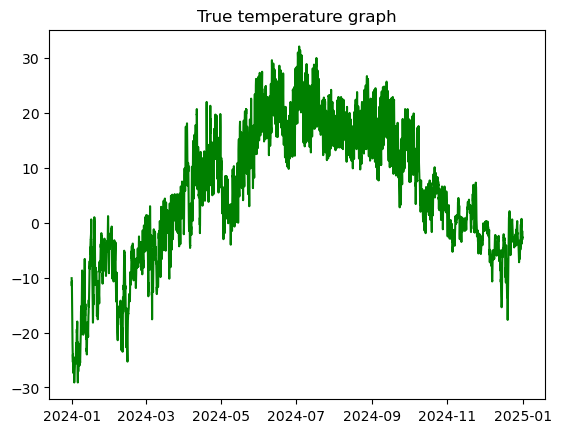

In [19]:
plot(plot_data, 'green', 'True temperature graph')

In [20]:
temp_predict = predictor.predict(data.drop('temperature_2m', axis=1))

In [21]:
#plot_predict = pd.DataFrame.from_dict({'time':data['time'][i:j+1].astype(int), 'key':temp_predict}).reset_index(drop=True)
i, j = get_period(begin, end)
plot_predict = get_slice_custom(begin, end, temp_predict[i:j+1])
plot_predict.head()

,time,key
0,1704056400,-10.120
1,1704060000,-10.542
2,1704063600,-11.006
3,1704067200,-11.517
4,1704070800,-10.687


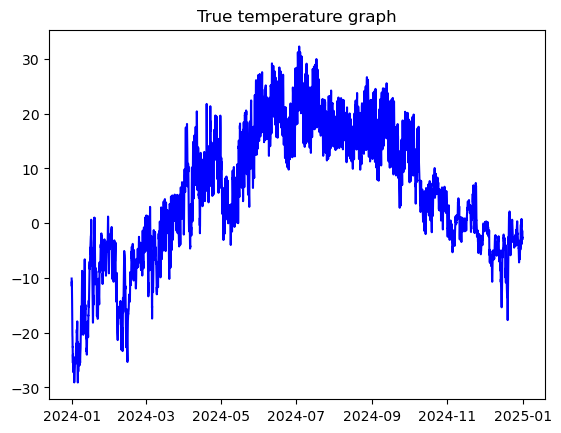

In [22]:
plot(plot_predict, 'blue', 'True temperature graph')

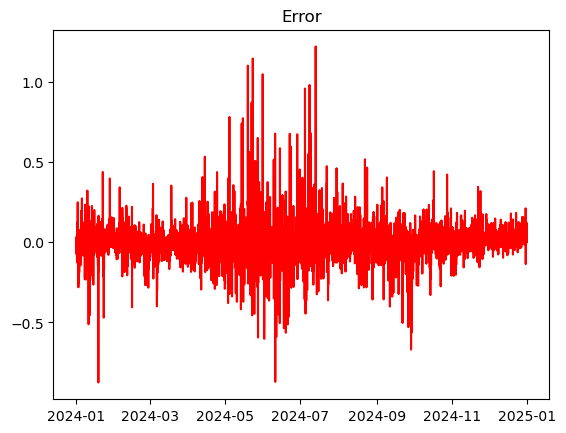

In [23]:
plt.plot(plot_predict['time'].to_numpy(), (plot_predict['key'].to_numpy()) - (plot_data['key'].to_numpy()), color='red')
plt.title('Error')
plt.show()

In [24]:
print("R2 Score: ",result['r2_score'])
print("Mean Squared Error: ",result['mean_squared_error'])

R2 Score:  0.9997840286325369
Mean Squared Error:  0.029944545952036106
